In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch
from torch.utils.data import DataLoader

In [60]:
def data_preprocess(data_dir, test=False):    
    data = pd.read_csv(data_dir)
    # remove None value
    data = data.dropna()
    # convert string to matrix
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values
    # data['Image']
    imgs = np.vstack(data['Image'].values)/255
    print(imgs.shape)
    imgs = imgs.reshape(data.shape[0], 96,96)
    imgs = imgs.astype(np.float32)

    if test ==False:
        points=data[data.columns[:-1]].values
        points=points/96-0.5
        points=points.astype(np.float32)

    imgs, points=shuffle(imgs, points)
    return imgs, points

In [61]:
x_train, y_train = data_preprocess('training.csv')
x_test, y_test = data_preprocess('test.csv')

(2140, 9216)
(1783, 9216)


In [4]:
# plt.imshow(x_train[0],cmap='gray')

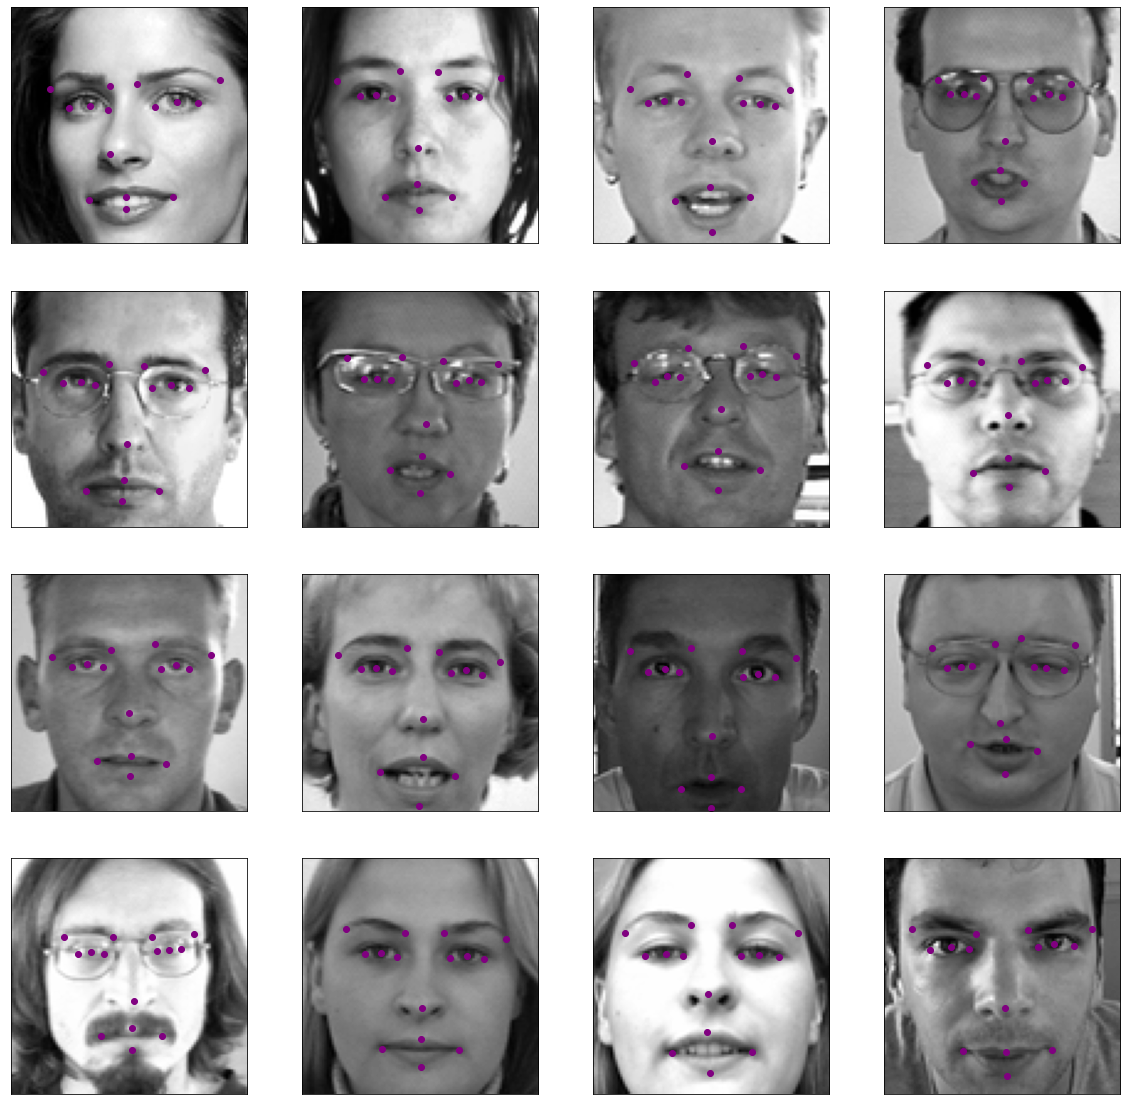

In [51]:
def draw_points(img, points):
    plt.imshow(img,cmap='gray')
#     print(points)
#     30 nums in the label_set for each pic
    for i in range(0,30,2):
        plt.scatter(((points[i]+0.5)*96), ((points[i+1]+0.5)*96), color='purple')
fig = plt.figure(figsize=(20,20))
for i in range(16):
    fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    draw_points(x_train[i], y_train[i])
plt.show()

In [6]:
# does data augmentation by flipping the image
def augment_data(img, points):
    rows, cols = img.shape
    new_img = np.copy(img)
    
    # flip the image
    for i in range(96):
        for j in range(48):
            temp = img[i][j]
            new_img[i][j] = img[i][cols-j-1]
            new_img[i][cols-j-1] = temp
            
    # flip the points
    new_points = np.copy(points)
    for i in range(0,30,2):
        new_points[i] = -points[i]
        
    return new_img, new_points

# flip_img, flip_points = augment_data(x_train[1], y_train[1])

aug_x_train = []
aug_y_train = []
for i in tqdm(range(0,x_train.shape[0])):
    aug_img, aug_point = augment_data(x_train[i], y_train[i])
    aug_x_train.append(aug_img)
    aug_y_train.append(aug_point)
aug_x_train = np.array(aug_x_train)
aug_y_train = np.array(aug_y_train)
aug_x_train.shape

100%|█████████████████████████████████████████████████████████████████████████████| 2140/2140 [00:10<00:00, 206.37it/s]


(2140, 96, 96)

Keras

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, History
from keras.optimizers import Adam
from keras.models import load_model

Using TensorFlow backend.


In [8]:
aug_imgs_train = aug_x_train.reshape(aug_x_train.shape[0], 96, 96, 1)
# imgs_val = imgs_val.reshape(imgs_val.shape[0], 96, 96, 1)

Pytorch

In [17]:
from torch.utils.data import Dataset
class batch_data(Dataset):
    def __init__(self, image_set, label):
        
        super(batch_data, self).__init__()
        self.label = label
        self.image_set = image_set
        
        self.createIndex()

    def createIndex(self):
        self.img_list = self.image_set
        self.label = self.label

    def __getitem__(self, idx):
#         img = torch.tensor(self.img_list[idx])
        
#         img = img.transpose(2, 0, 1)
        sample = {'img': self.img_list[idx],
                  'label': self.label[idx],
                  }
#         print(sample)
        return sample


    # data_loader cause error without __len__()
    def __len__(self):
        return len(self.img_list)


    @staticmethod
    def collate(batch):
        if isinstance(batch[0]['img'], torch.Tensor):
            img = torch.stack([b['img'] for b in batch])
        else:
            img = [b['img'] for b in batch]

        if batch[0]['label'] is None:
            Label = None
        elif isinstance(batch[0]['label'], torch.Tensor):
            Label = torch.stack([b['label'] for b in batch])
        else:
            Label = [b['label'] for b in batch]

        samples = {'img': img,
                   'label': Label}
#         print(len(samples['label']), len(samples['img']))     
        return samples

In [62]:
aug_x_train.shape

(2000, 1, 96, 96)

In [18]:
# reshape image for training
# print(aug_x_train.shape, aug_y_train.shape)
aug_train = aug_x_train.reshape(aug_x_train.shape[0], 1, 96,96)

aug_x_train=aug_train[0:2000]
aug_x_val = aug_train[2001:]


aug_y_train = y_train[0:2000]
aug_y_val = y_train[2001:]

train_dataset = batch_data(aug_x_train, aug_y_train)
val_dataset = batch_data(aug_x_val, aug_y_val)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=8,
                          collate_fn=train_dataset.collate,
                          shuffle=True, num_workers= 0)

val_loader = DataLoader(val_dataset, batch_size=8,
                          collate_fn=val_dataset.collate,
                          shuffle=True, num_workers= 0)

In [22]:
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self, outputs=30):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*12*12, 1024)
        self.fc2 = nn.Linear(1024, outputs)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(self.dropout(x))
        
        return x
#     def __init__(self):
#         super(Net, self).__init__()
# #         self.features = features
        
#         self.layer = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2),
            
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d((2,2)),
            
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d((2,2)),
            
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
        
#         self.linear1=nn.Sequential(
#             nn.Linear(128*4*4,512),
#             nn.ReLU(),
#             nn.Dropout(0.2)
#         )
        
#         self.linear2=nn.Sequential(   
#             nn.Linear(512,30),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#         )
        
# #         self.linear3=nn.Sequential(
# #             nn.linear(30)
# #         )
        
#     def forward(self, x):
        
#         x = self.layer(x)
# #         print(x.shape)
#         x = x.view(-1, 128*4*4)
#         x = self.linear1(x)
# #         print(x.shape)
#         x = self.linear2(x)
# #         print(x.shape)
# #         x.view()
# #         x = self.linear3(x)
#         return x
    

In [23]:
import torch.optim as optim

face_net = Net()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, 
                                    face_net.parameters()), lr=0.001)

lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


face_net.train()
for e in range(10):
    print(e)
    for i, sample in enumerate(train_loader):
        img = torch.tensor(np.array(sample['img']))
#             img = img.reshape(img.shape[0], 96, 96, 1)
#             print(img.shape, type(img))

        input_ = img.to(device)
#             print(input_.shape)
#             

        label_ = torch.tensor(sample['label']).to(device)

        optimizer.zero_grad()
        pred = face_net(input_)
#             print(pred.shape, label_.shape)
        loss = criterion(pred, label_)
        print(loss)
        loss.backward()
        optimizer.step()

0
tensor(0.0407, grad_fn=<MseLossBackward>)
tensor(0.0582, grad_fn=<MseLossBackward>)
tensor(0.0058, grad_fn=<MseLossBackward>)
tensor(0.0137, grad_fn=<MseLossBackward>)
tensor(0.0142, grad_fn=<MseLossBackward>)
tensor(0.0120, grad_fn=<MseLossBackward>)
tensor(0.0069, grad_fn=<MseLossBackward>)
tensor(0.0045, grad_fn=<MseLossBackward>)
tensor(0.0033, grad_fn=<MseLossBackward>)
tensor(0.0070, grad_fn=<MseLossBackward>)
tensor(0.0059, grad_fn=<MseLossBackward>)
tensor(0.0032, grad_fn=<MseLossBackward>)
tensor(0.0024, grad_fn=<MseLossBackward>)
tensor(0.0041, grad_fn=<MseLossBackward>)
tensor(0.0058, grad_fn=<MseLossBackward>)
tensor(0.0043, grad_fn=<MseLossBackward>)
tensor(0.0031, grad_fn=<MseLossBackward>)
tensor(0.0026, grad_fn=<MseLossBackward>)
tensor(0.0041, grad_fn=<MseLossBackward>)
tensor(0.0029, grad_fn=<MseLossBackward>)
tensor(0.0021, grad_fn=<MseLossBackward>)
tensor(0.0024, grad_fn=<MseLossBackward>)
tensor(0.0019, grad_fn=<MseLossBackward>)
tensor(0.0015, grad_fn=<MseLossB

tensor(0.0014, grad_fn=<MseLossBackward>)
tensor(0.0011, grad_fn=<MseLossBackward>)
tensor(0.0014, grad_fn=<MseLossBackward>)
tensor(0.0021, grad_fn=<MseLossBackward>)
tensor(0.0023, grad_fn=<MseLossBackward>)
tensor(0.0019, grad_fn=<MseLossBackward>)
tensor(0.0014, grad_fn=<MseLossBackward>)
tensor(0.0016, grad_fn=<MseLossBackward>)
tensor(0.0014, grad_fn=<MseLossBackward>)
tensor(0.0017, grad_fn=<MseLossBackward>)
tensor(0.0016, grad_fn=<MseLossBackward>)
tensor(0.0011, grad_fn=<MseLossBackward>)
tensor(0.0011, grad_fn=<MseLossBackward>)
tensor(0.0017, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0015, grad_fn=<MseLossBackward>)
tensor(0.0012, grad_fn=<MseLossBackward>)
tensor(0.0011, grad_fn=<MseLossBackward>)
tensor(0.0011, grad_fn=<MseLossBackward>)
tensor(0.0009, grad_fn=<MseLossBackward>)
tensor(0.0015, grad_fn=<MseLossBackward>)
tensor(0.0014, grad_fn=<MseLossBackward>)
tensor(0.0028, grad_fn=<MseLossBackward>)
tensor(0.0009, grad_fn=<MseLossBac

tensor(0.0013, grad_fn=<MseLossBackward>)
tensor(0.0013, grad_fn=<MseLossBackward>)
tensor(0.0012, grad_fn=<MseLossBackward>)
tensor(0.0016, grad_fn=<MseLossBackward>)
tensor(0.0014, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0014, grad_fn=<MseLossBackward>)
tensor(0.0010, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0014, grad_fn=<MseLossBackward>)
tensor(0.0017, grad_fn=<MseLossBackward>)
tensor(0.0009, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0019, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0010, grad_fn=<MseLossBackward>)
tensor(0.0010, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0010, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0010, grad_fn=<MseLossBac

tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0009, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0012, grad_fn=<MseLossBackward>)
tensor(0.0011, grad_fn=<MseLossBackward>)
tensor(0.0009, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0009, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0010, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0012, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0010, grad_fn=<MseLossBackward>)
tensor(0.0017, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0010, grad_fn=<MseLossBackward>)
tensor(0.0014, grad_fn=<MseLossBackward>)
tensor(0.0009, grad_fn=<MseLossBac

tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0010, grad_fn=<MseLossBackward>)
tensor(0.0011, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0011, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0009, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0013, grad_fn=<MseLossBac

tensor(0.0002, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0009, grad_fn=<MseLossBackward>)
tensor(0.0009, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0009, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0012, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0009, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0009, grad_fn=<MseLossBackward>)
tensor(0.0011, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
4
tensor(0.0005, grad_fn=<MseLossB

tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0009, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBac

tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBac

tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0018, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBac

tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0002, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBac

tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBac

tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0002, grad_fn=<MseLossBackward>)
tensor(0.0002, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBac

tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0002, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0002, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0002, grad_fn=<MseLossBackward>)
tensor(0.0002, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0002, grad_fn=<MseLossBackward>)
tensor(0.0002, grad_fn=<MseLossBackward>)
tensor(0.0002, grad_fn=<MseLossBackward>)
tensor(0.0004, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBackward>)
tensor(0.0003, grad_fn=<MseLossBac

In [56]:
x_test[0].shape

(96, 96)

IndexError: index 8 is out of bounds for axis 0 with size 8

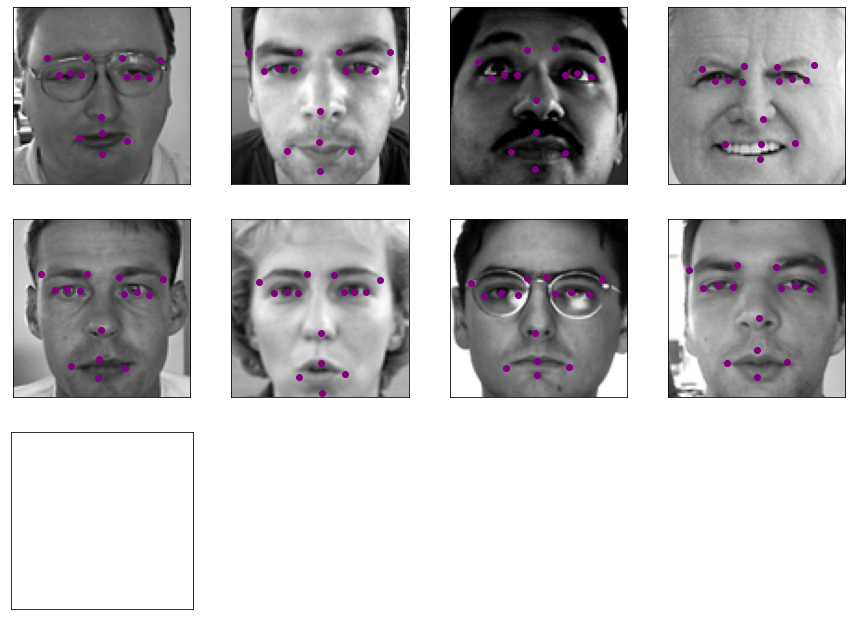

In [59]:
import cv2
face_net.train()
def draw_points(img, points):
    plt.imshow(img,cmap='gray')
#     print(points)
#     30 nums in the label_set for each pic
    for i in range(0,30,2):
        plt.scatter(((points[i]+0.5)*96), ((points[i+1]+0.5)*96), color='purple')
for i, sample in enumerate(train_loader):
    img = torch.tensor(np.array(sample['img']))
    out_put = (face_net(img).cpu()).detach().numpy()
    
    img = np.array(img.cpu())
    
        
        # output[::2] = [l_o * 640 + 640 for l_o in output[::2]]
        # output[1::2] = [l_e * 360 + 360 for l_e in output[1::2]]
        # out_put[::2] = [(l_o * 112+112)/ratio_x for l_o in out_put[::2]]
        # out_put[1::2] = [(l_e * 112+112)/ratio_y for l_e in out_put[1::2]]

#         output[::2] = [(l_o+0.5)*224 for l_o in output[::2]]
#         output[1::2] = [(l_e+0.5)*224 for l_e in output[1::2]]
#         print('after mapping', output)

#         points = [tuple(output[i:i + 2]) for i in range(0, len(output), 2)]
#         print(points)
    fig = plt.figure(figsize=(15,15))

    for i in range(9):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        draw_points(img[i][0], out_put[i])